# Importing Libraries

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Gaussian Smoothing

In [12]:
def gauss(im, sigm):
    kern = int(6 * sigm + 1) | 1
    return cv2.GaussianBlur(im, (kern, kern), sigmaX= sigm)

# Gradient Magnitude and Direction

In [13]:
def comp_gradi(im, grad_met ="sobel"):
    if grad_met == "sobel":
        grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)
    elif grad_met == "roberts":
        roberts_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
        roberts_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
        grad_x = cv2.filter2D(im, cv2.CV_64F, roberts_x)
        grad_y = cv2.filter2D(im, cv2.CV_64F, roberts_y)
    elif grad_met == "zerocross":
        laplacian = cv2.Laplacian(im, cv2.CV_64F)
        grad_x = laplacian.copy()
        grad_y = laplacian.copy()
    mag = np.sqrt(grad_x**2 + grad_y**2)
    dire = np.arctan2(grad_y, grad_x) * (180 / np.pi)
    dire[dire < 0] += 180
    return mag, dire   

# Adaptive Thresholding

In [14]:
def adapti_threshold(mag, non_edge_perc = 0.7):
    hist, bins = np.histogram(mag, bins=256, range=(0, 256))
    cumu_hist = np.cumsum(hist)/mag.size
    high_thre = np.argmax(cumu_hist > non_edge_perc)
    low_thres = 0.4 * high_thre
    return low_thres, high_thre

# Non Maximum Supression

In [15]:
def suppress_non_max(mag, dire):
    rows, cols = mag.shape
    supres = np.zeros_like(mag, dtype=np.float32)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            theta = dire[i, j]
            q, r = 255, 255
            if (0 <= theta < 22.5) or (157.5 <= theta <= 180):
                q, r = mag[i, j + 1], mag[i, j - 1]
            elif 22.5 <= theta < 67.5:
                q, r = mag[i + 1, j - 1], mag[i - 1, j + 1]
            elif 67.5 <= theta < 112.5:
                q, r = mag[i + 1, j], mag[i - 1, j]
            elif 112.5 <= theta < 157.5:
                q, r = mag[i - 1, j - 1], mag[i + 1, j + 1]

            if mag[i, j] >= q and mag[i, j] >= r:
                supres[i, j] = mag[i, j]
            else:
                supres[i, j] = 0
    return supres

# Edge Linking

In [16]:
def link_edges(supres, low_thresh, high_thresh):
    rows, cols = supres.shape
    final_edges = np.zeros_like(supres, dtype=np.uint8)
    strong_edges = (supres > high_thresh).astype(np.uint8) * 255
    weak_edges = ((supres >= low_thresh) & (supres <= high_thresh)).astype(np.uint8) * 255
    def dfs(x, y):
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if final_edges[cx, cy] == 0 and supres[cx, cy] > low_thresh:
                final_edges[cx, cy] = 255
                neighbors = [
                    (cx + 1, cy), (cx - 1, cy), (cx, cy + 1), (cx, cy - 1),
                    (cx + 1, cy + 1), (cx - 1, cy - 1), (cx + 1, cy - 1), (cx - 1, cy + 1)
                ]
                for nx, ny in neighbors:
                    if 0 <= nx < rows and 0 <= ny < cols:
                        stack.append((nx, ny))
    for i in range(rows):
        for j in range(cols):
            if strong_edges[i, j] > 0 and final_edges[i, j] == 0:
                dfs(i, j)
    return final_edges

# Different Edge Detectors

In [17]:
def compare_detectors(im):
    sobel_edges = cv2.Canny(im, 100, 200)
    roberts_edges = cv2.Canny(im, 50, 150)
    zerocross_edges = cv2.Laplacian(im, cv2.CV_64F)
    zerocross_edges = np.uint8(np.absolute(zerocross_edges))
    return {
        "Sobel": sobel_edges,
        "Roberts": roberts_edges,
        "Zero-Crossing": zerocross_edges
    }

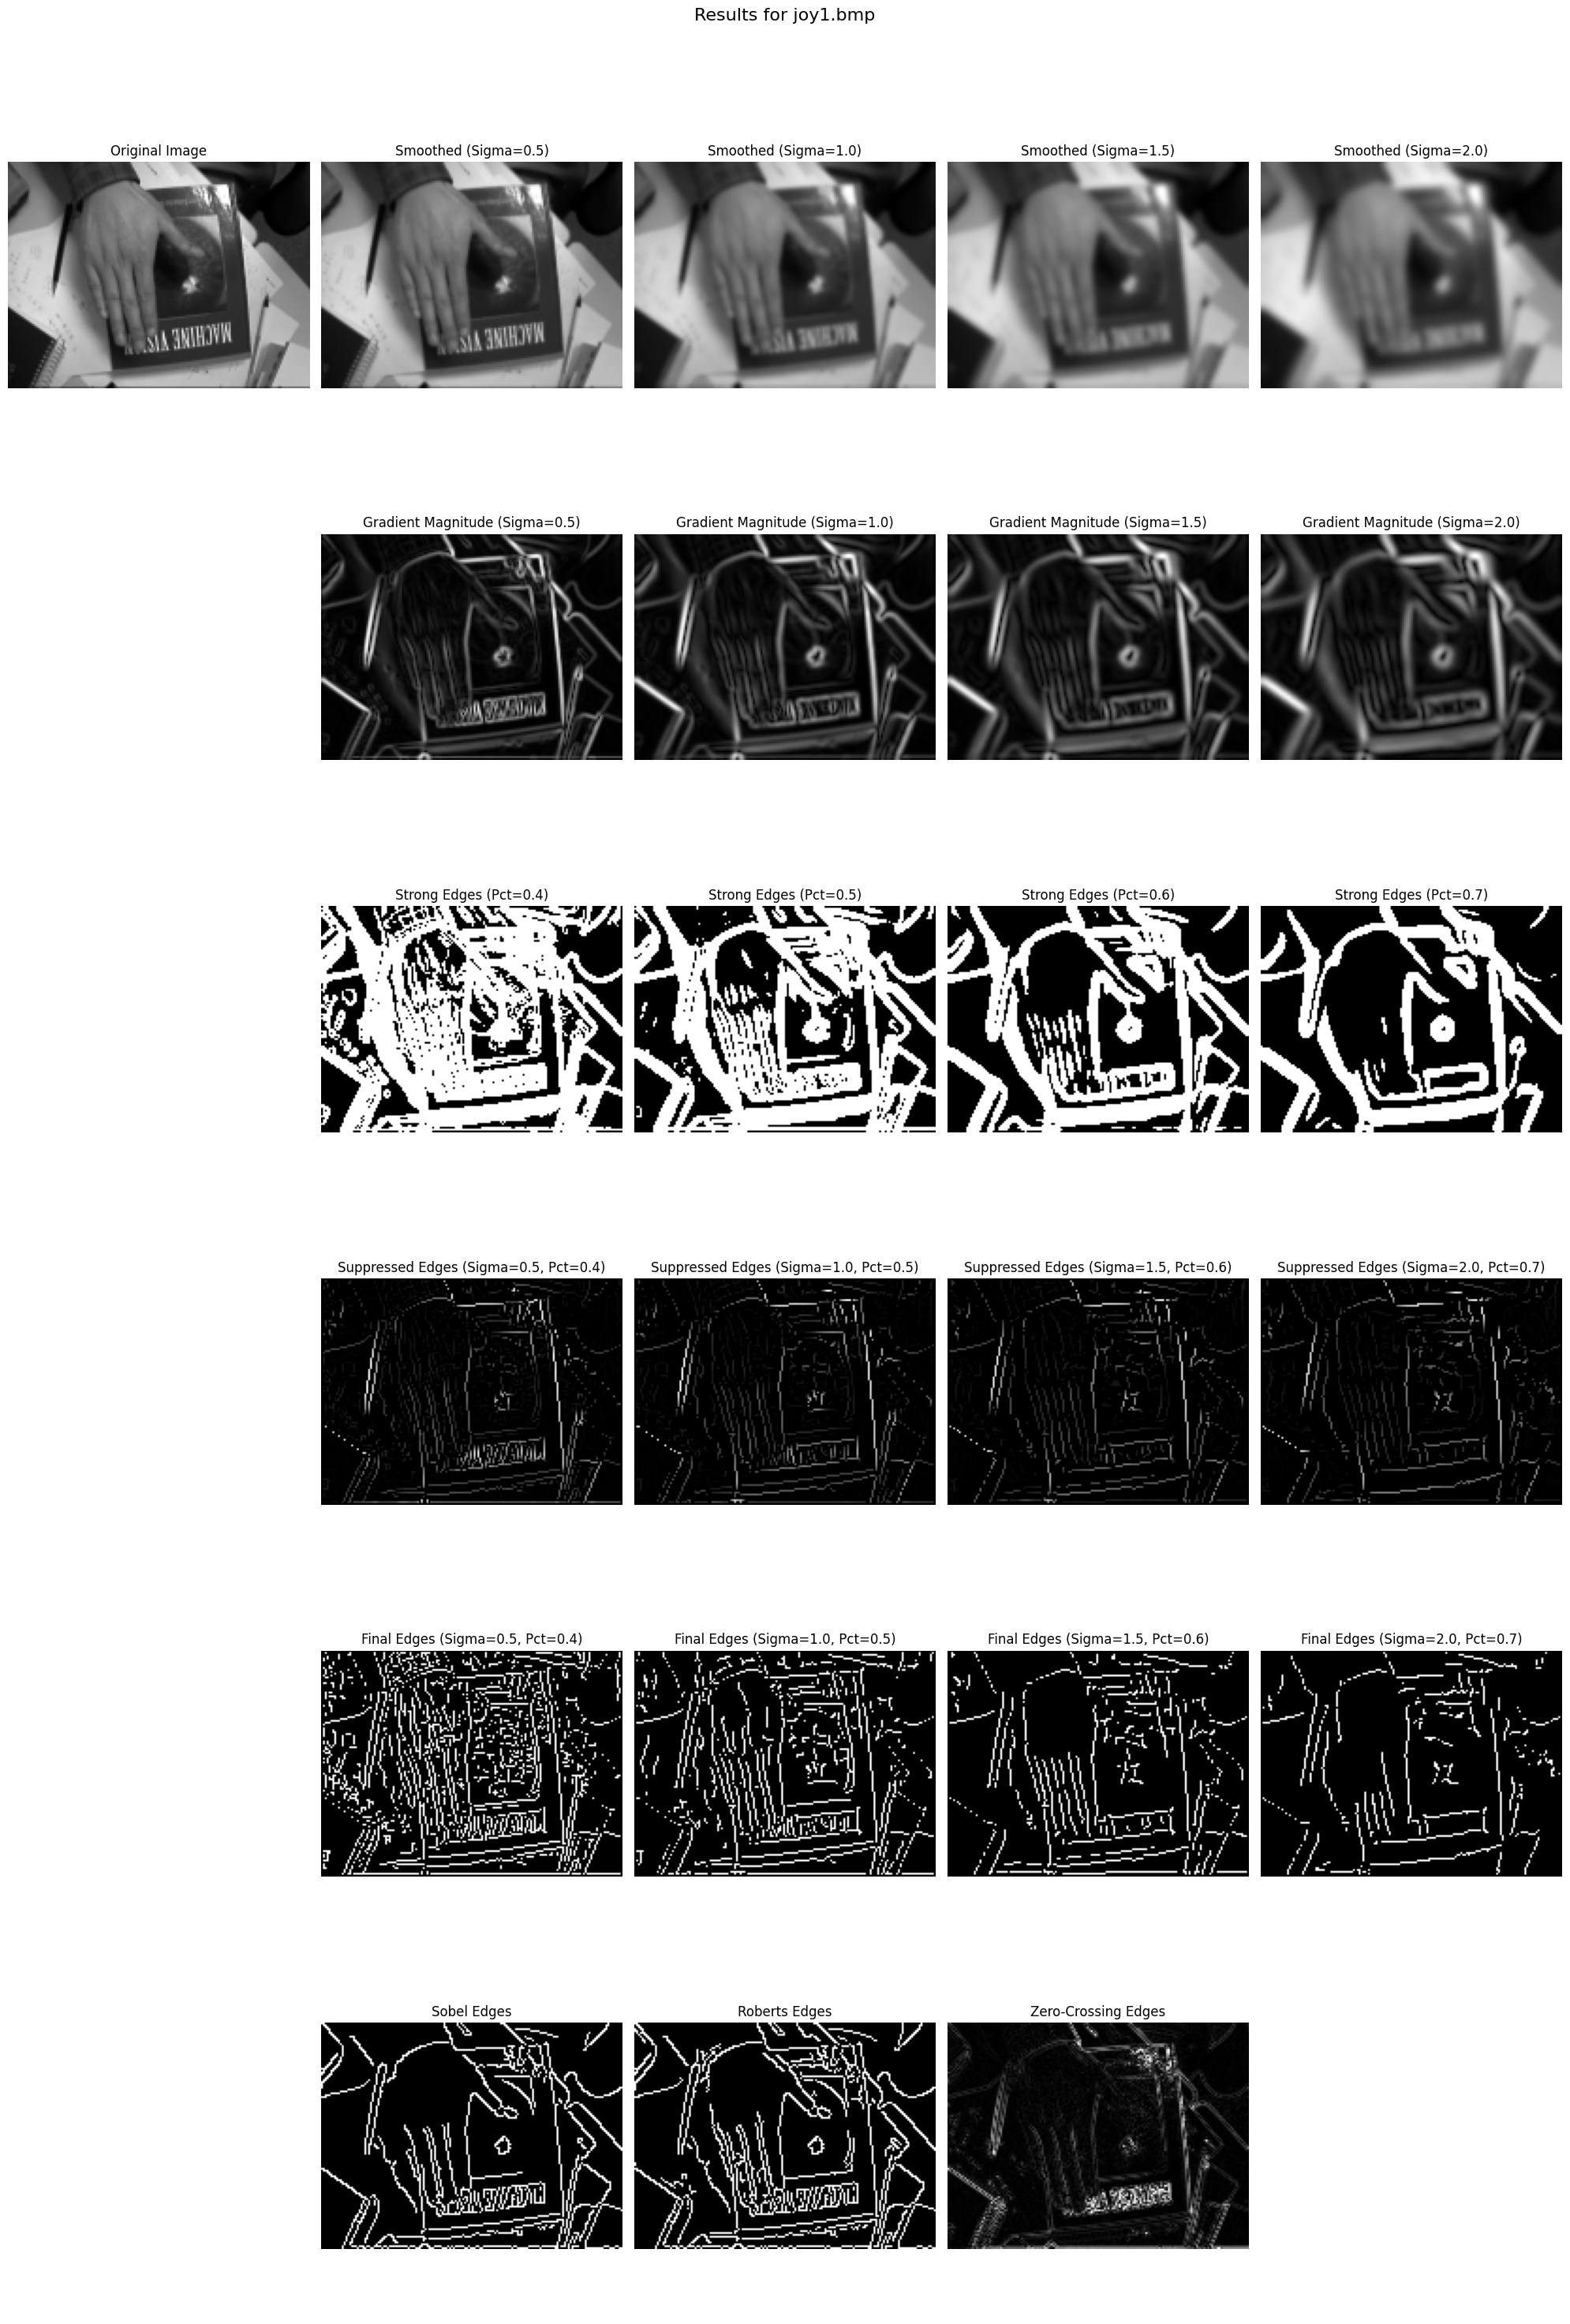

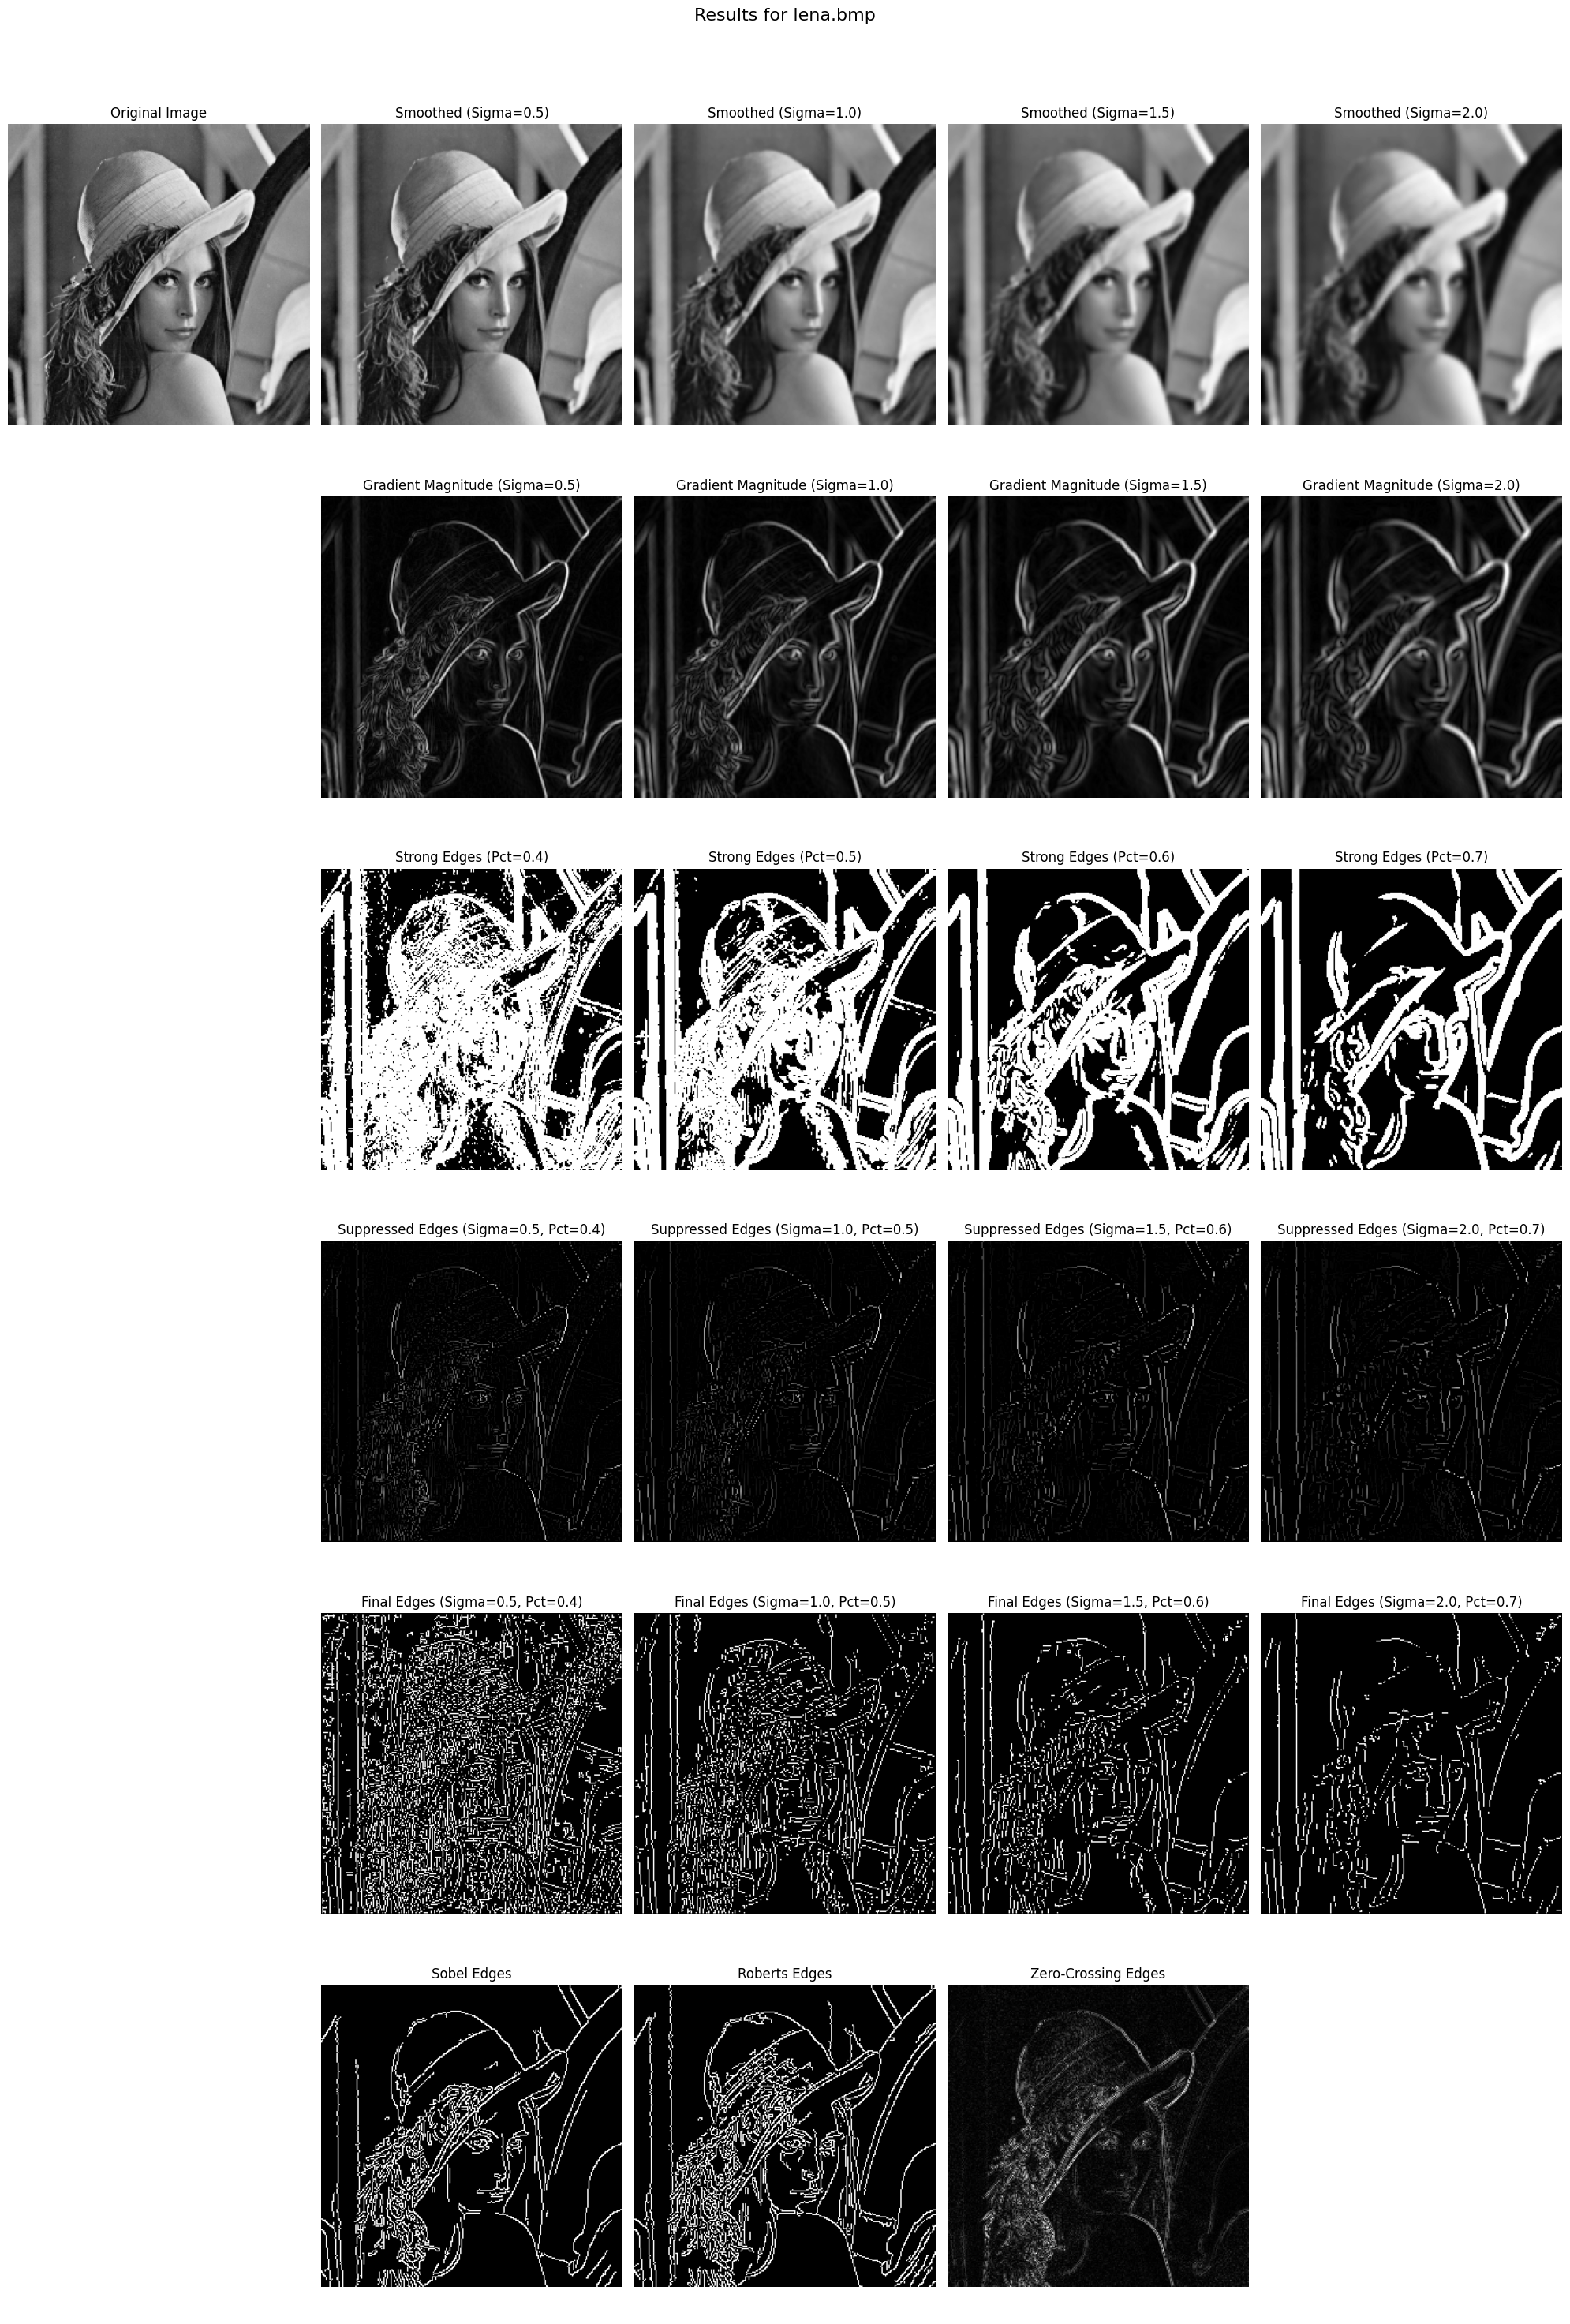

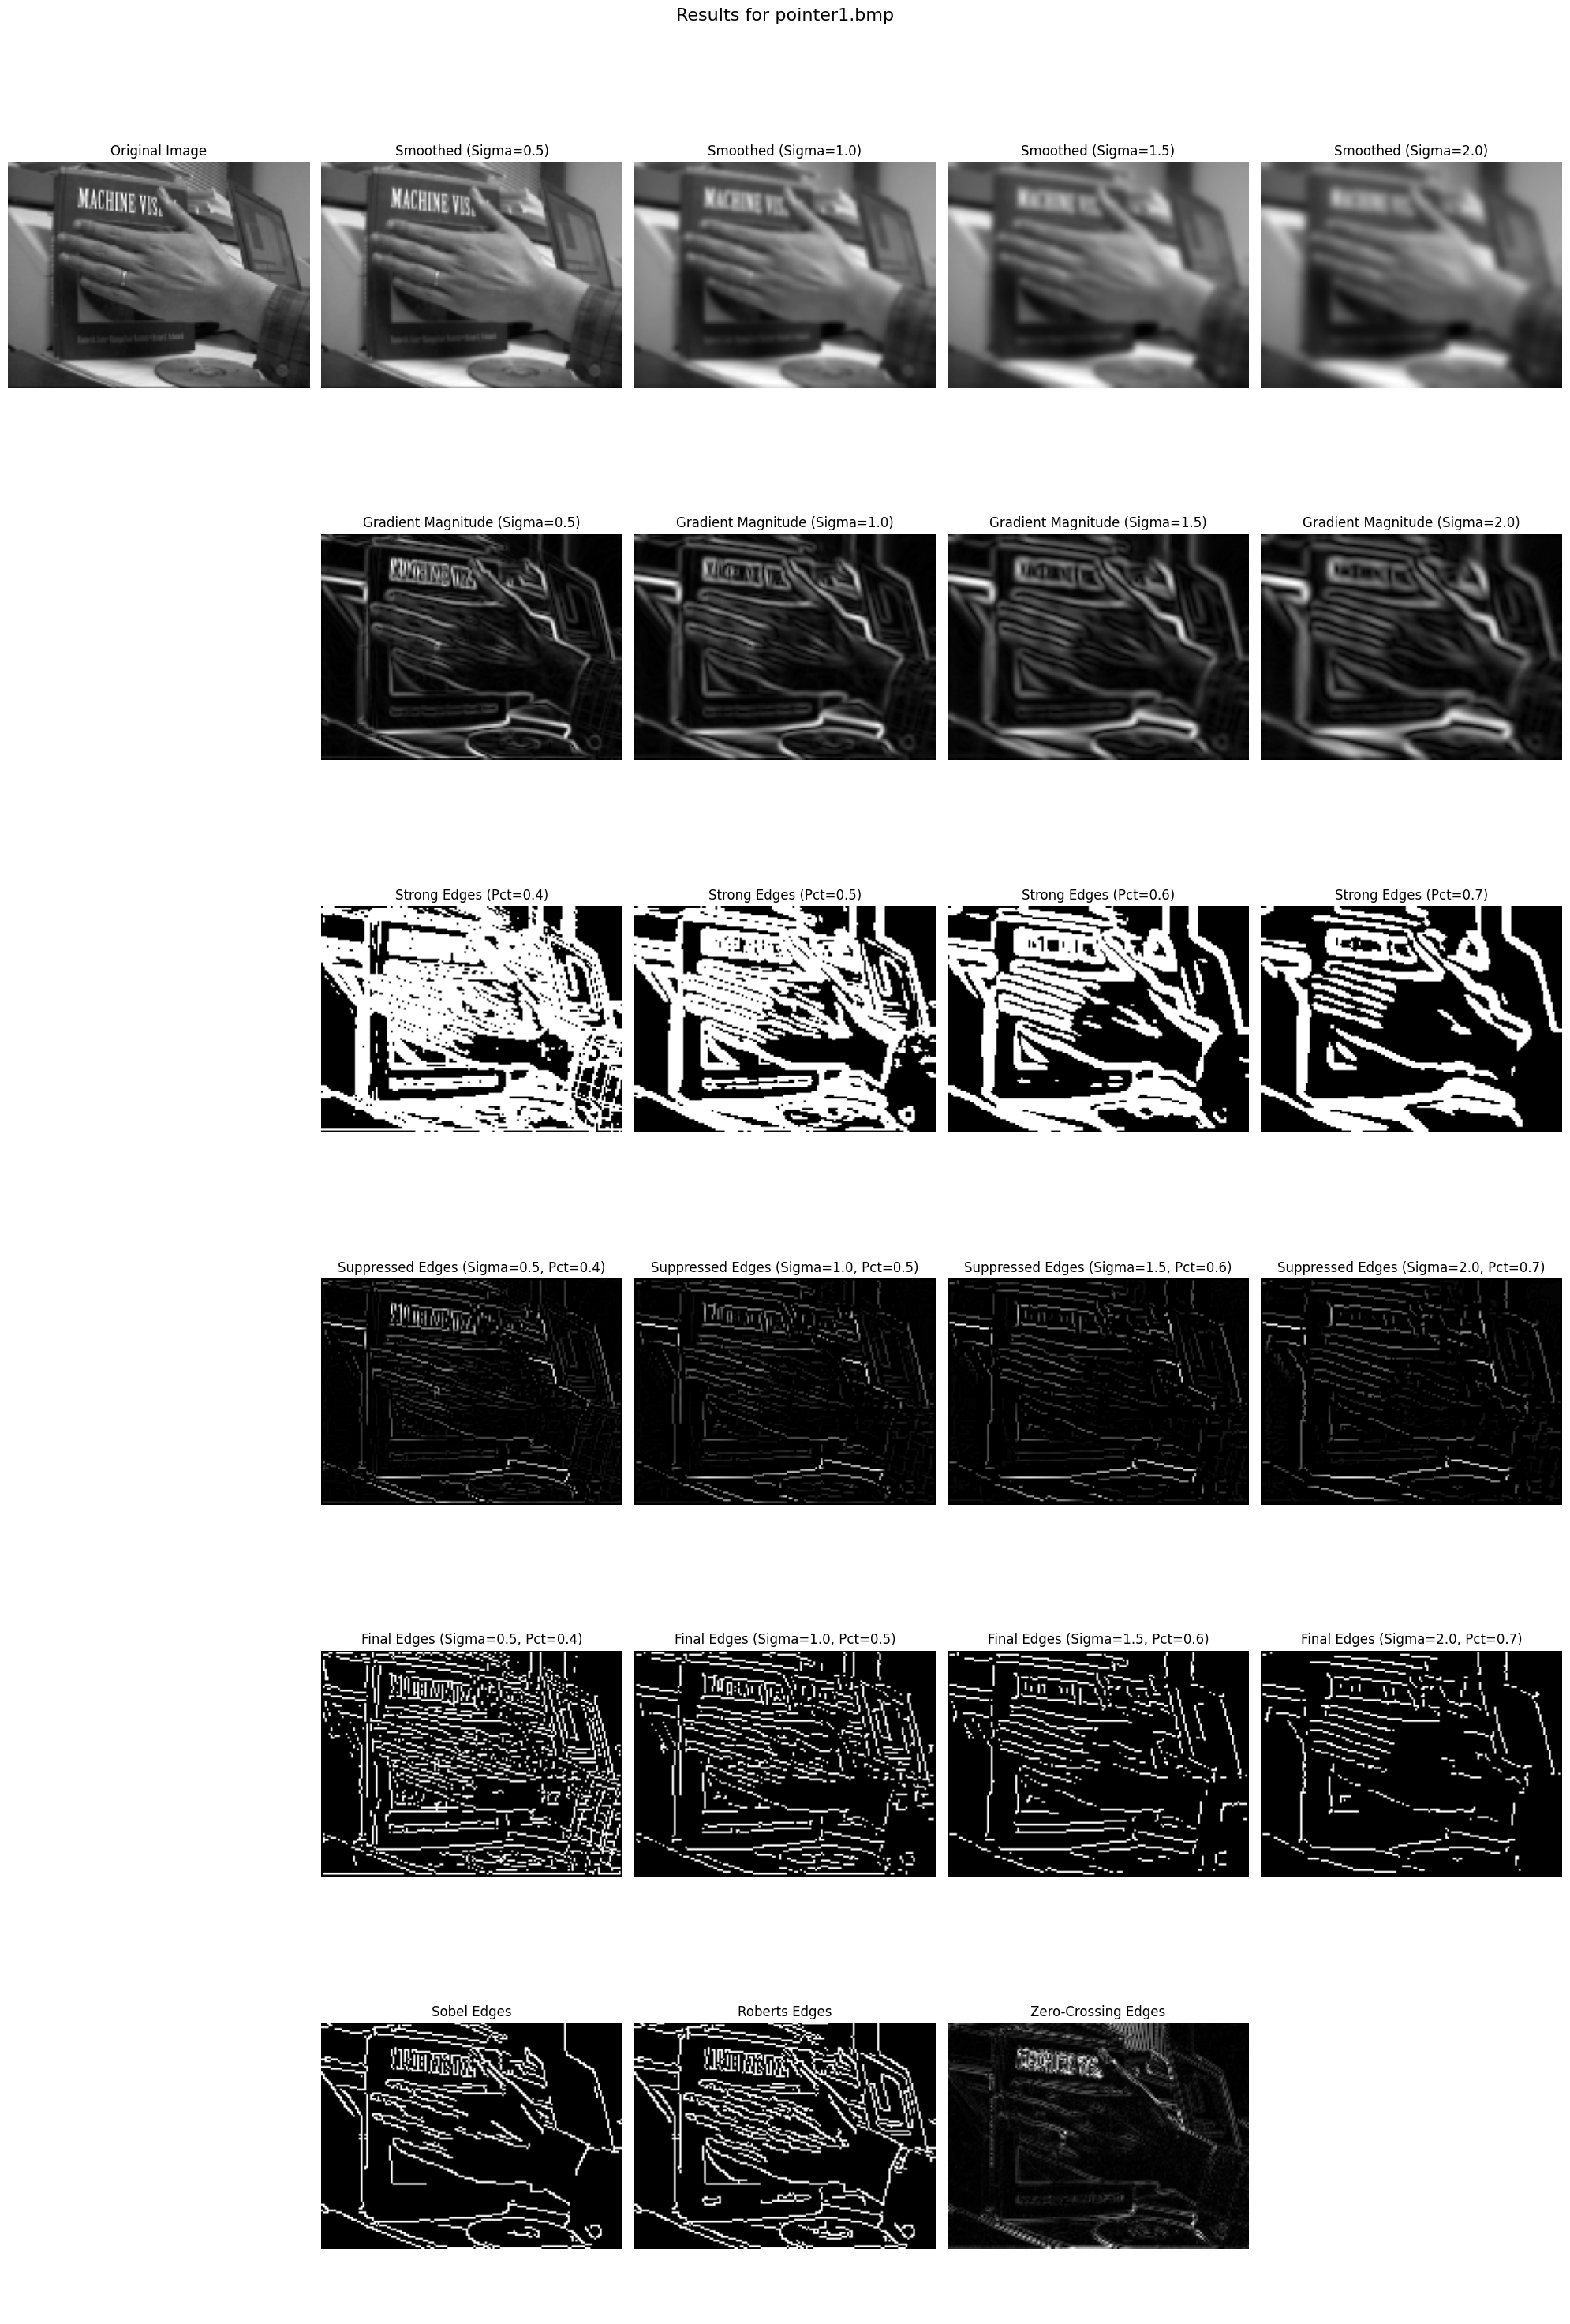

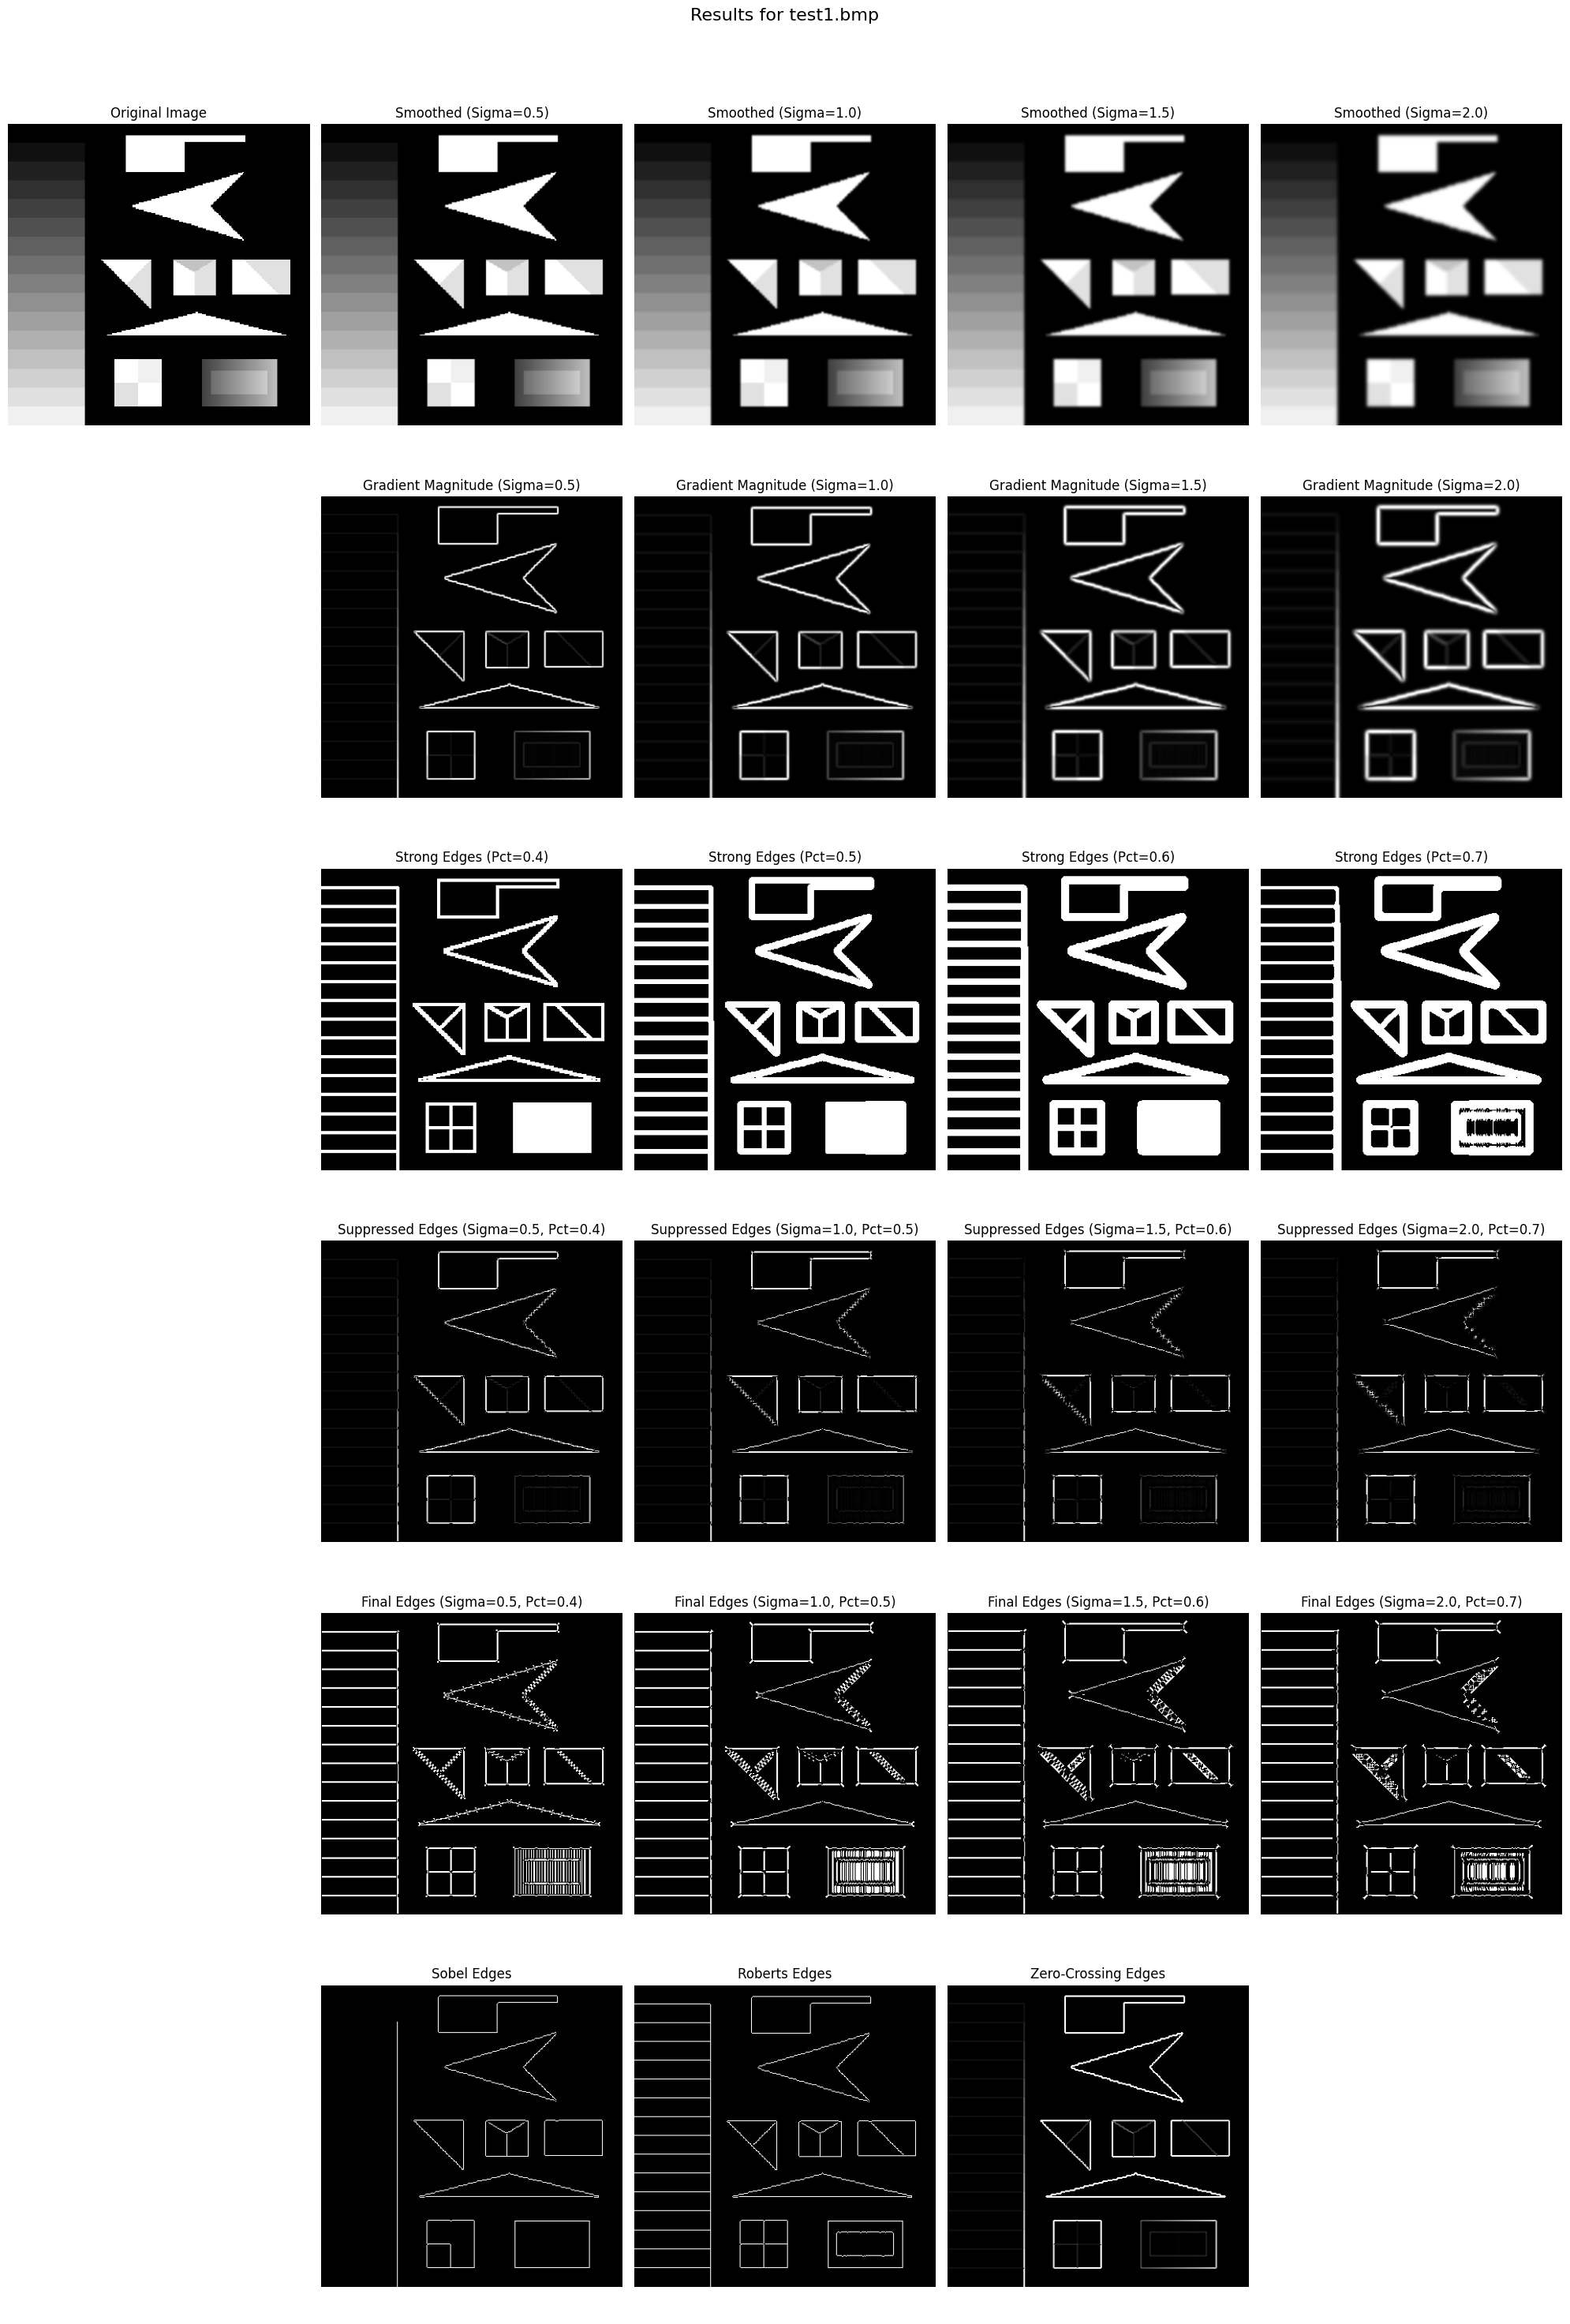

In [19]:
def main():
    test_images = ["joy1.bmp", "lena.bmp", "pointer1.bmp", "test1.bmp"]

    for img_path in test_images:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Could not load {img_path}. Skipping...")
            continue
        sigma_values = [0.5, 1.0, 1.5, 2.0]
        non_edge_percentages = [0.4, 0.5, 0.6, 0.7]
        num_cols = len(sigma_values) + 1
        num_rows = 6
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))
        fig.suptitle(f"Results for {img_path}", fontsize=16)
        axes[0, 0].imshow(image, cmap='gray')
        axes[0, 0].set_title("Original Image")
        axes[0, 0].axis('off')
        for idx, (sigma, pct) in enumerate(zip(sigma_values, non_edge_percentages)):
            col = idx + 1
            smoothed = gauss(image, sigma)
            axes[0, col].imshow(smoothed, cmap='gray')
            axes[0, col].set_title(f"Smoothed (Sigma={sigma})")
            axes[0, col].axis('off')
            magnitude, direction = comp_gradi(smoothed, grad_met="sobel")
            axes[1, col].imshow(magnitude, cmap='gray')
            axes[1, col].set_title(f"Gradient Magnitude (Sigma={sigma})")
            axes[1, col].axis('off')
            low_thresh, high_thresh = adapti_threshold(magnitude, pct)
            strong_edges = (magnitude > high_thresh).astype(np.uint8) * 255
            weak_edges = ((magnitude >= low_thresh) & (magnitude <= high_thresh)).astype(np.uint8) * 255
            axes[2, col].imshow(strong_edges, cmap='gray')
            axes[2, col].set_title(f"Strong Edges (Pct={pct})")
            axes[2, col].axis('off')
            suppressed = suppress_non_max(magnitude, direction)
            axes[3, col].imshow(suppressed, cmap='gray')
            axes[3, col].set_title(f"Suppressed Edges (Sigma={sigma}, Pct={pct})")
            axes[3, col].axis('off')
            final_edges = link_edges(suppressed, low_thresh, high_thresh)
            axes[4, col].imshow(final_edges, cmap='gray')
            axes[4, col].set_title(f"Final Edges (Sigma={sigma}, Pct={pct})")
            axes[4, col].axis('off')
        detector_results = compare_detectors(image)
        for idx, (detector_name, edges) in enumerate(detector_results.items()):
            axes[5, idx + 1].imshow(edges, cmap='gray')
            axes[5, idx + 1].set_title(f"{detector_name} Edges")
            axes[5, idx + 1].axis('off')
        for row in range(num_rows):
            for col in range(num_cols):
                if row == 5 and col > len(detector_results):
                    axes[row, col].axis('off')
                elif row != 0 and col == 0:
                    axes[row, col].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if __name__ == "__main__":
    main()